In [112]:
import numpy as np
import scipy.stats as sps
from scipy.ndimage import gaussian_filter
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import sys
from netCDF4 import Dataset

sys.path.append(r'C:\Users\chral\Nextcloud\code\HIDA2020\Climate_Model_Data')
from common import *

os.chdir(r'C:\Users\chral\Dropbox\ipp\HIDA2020')

First we load the time-series data of the forcing data to see how they look like.

Text(0.5, 1.0, 'Solar forcing')

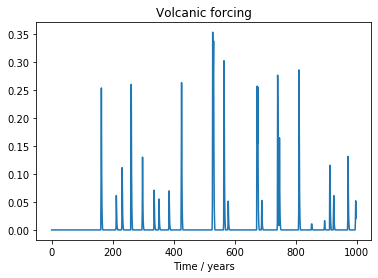

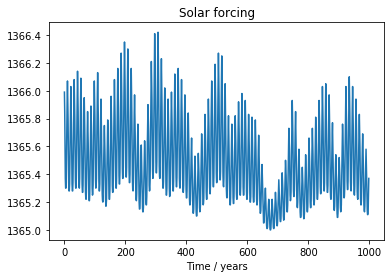

In [22]:
_, AOD = get_volcanic_data()
_, TSI = get_solar_data()

t = np.arange(len(AOD))

plt.figure()
plt.plot(t, AOD)
plt.xlabel('Time / years')
plt.title('Volcanic forcing')
plt.figure()
plt.plot(t, TSI)
plt.xlabel('Time / years')
plt.title('Solar forcing')

We notice a very different kind of time-series. While the volcanic forcing is mostly zero with distinct peaks, the solar data is strongly periodic on top of a slow trend. Let's have a look at the frequecy domain:

Text(0.5, 1.0, 'Solar forcing in frequency space')

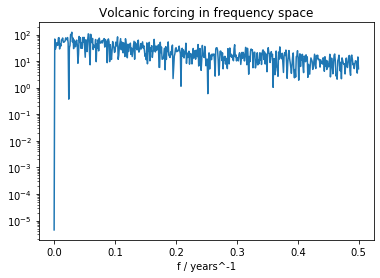

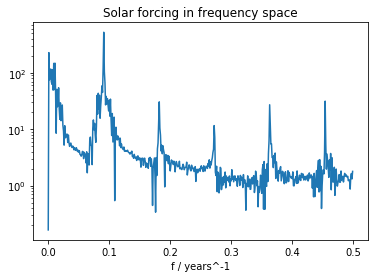

In [5]:
AOD_f = np.fft.rfft(normalize(AOD))
TSI_f = np.fft.rfft(normalize(TSI))
f = np.fft.fftfreq(len(TSI))[0:len(TSI_f)]

plt.figure()
plt.semilogy(f, np.abs(AOD_f))
plt.xlabel('f / years^-1')
plt.title('Volcanic forcing in frequency space')

plt.figure()
plt.semilogy(f, np.abs(TSI_f))
plt.xlabel('f / years^-1')
plt.title('Solar forcing in frequency space')

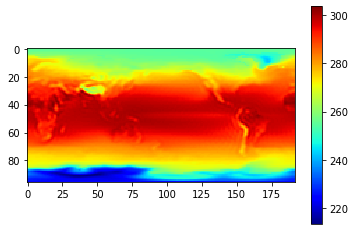

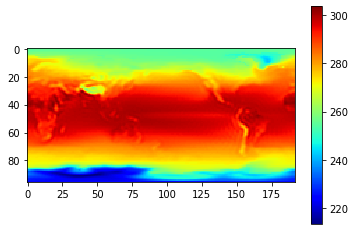

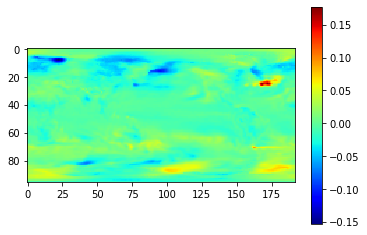

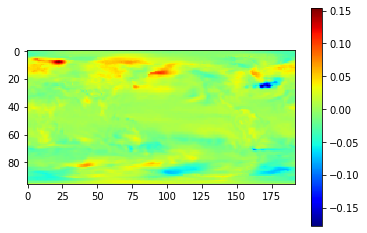

In [21]:
# Load temperature data
# The mean over time differs by less than 0.05% locally, so this is a good basis

_, lon, lat, T1 = get_geodata(1)
_, _, _, T2 = get_geodata(2)
T1_mean = np.mean(T1, 0)
T2_mean = np.mean(T2, 0)
T_mean = (T1_mean + T2_mean)/2.0

dT1 = T1-T1_mean
dT2 = T2-T2_mean

plt.figure()
plt.imshow(T1_mean, cmap='jet')
plt.colorbar()
plt.figure()
plt.imshow(T2_mean, cmap='jet')
plt.colorbar()
plt.figure()
plt.imshow(T1_mean-T_mean, cmap='jet')
plt.colorbar()
plt.figure()
plt.imshow(T2_mean-T_mean, cmap='jet')
plt.colorbar()

(500, 600)

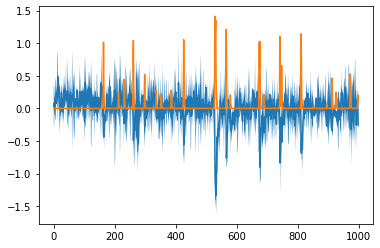

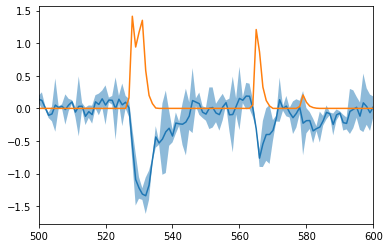

In [27]:
dT1glob = np.mean(np.mean(dT1, 2), 1)
dT2glob = np.mean(np.mean(dT2, 2), 1)
dTglob = (dT1glob + dT2glob)/2.0
var_dTglob = (dT1glob - dTglob)**2 + (dT2glob - dTglob)**2  # sample variance with n-1 = 1
err_dTglob = 1.96*np.sqrt(var_dTglob)

plt.figure()
plt.plot(t, dTglob)
plt.fill_between(t, dTglob - err_dTglob, dTglob + err_dTglob)
plt.plot(t, 4*AOD)

plt.figure()
plt.plot(t, dTglob)
plt.fill_between(t, dTglob - err_dTglob, dTglob + err_dTglob, alpha=0.5)
plt.plot(t, 4*AOD)
plt.xlim([500, 600])

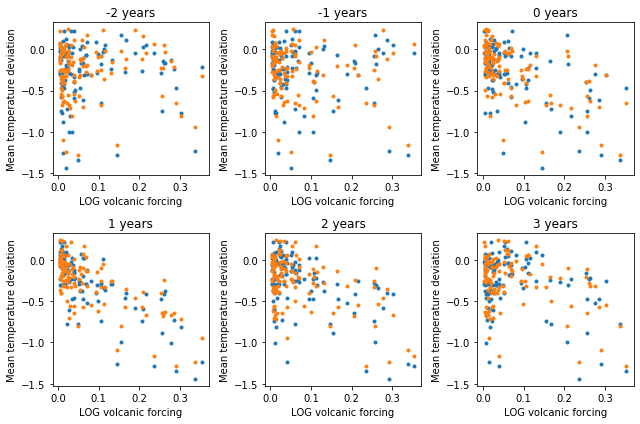

In [38]:
AODmin = 1e-2*np.max(AOD)

x = AOD[AOD>AODmin]

plt.figure(figsize=(9, 6))
for lag in range(-2, 4):
    yA = np.roll(dT1glob[AOD>AODmin], -lag)
    yB = np.roll(dT2glob[AOD>AODmin], -lag)
    plt.subplot(2, 3, lag+3)
    plt.plot(x, yA, '.')
    plt.plot(x, yB, '.')
    plt.ylabel('Mean temperature deviation')
    plt.xlabel('LOG volcanic forcing')
    plt.title('{} years'.format(lag))
plt.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     263.2
Date:                Thu, 02 Apr 2020   Prob (F-statistic):           1.15e-39
Time:                        23:23:22   Log-Likelihood:                 20.826
No. Observations:                 226   AIC:                            -37.65
Df Residuals:                     224   BIC:                            -30.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1024      0.027      3.748      0.0

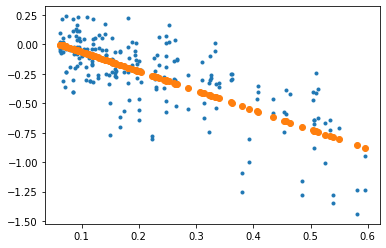

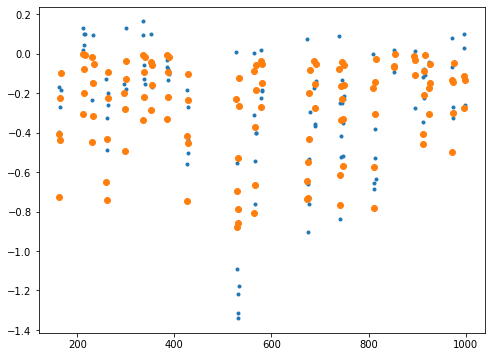

In [106]:
x = np.sqrt(np.concatenate([AOD[AOD>AODmin],AOD[AOD>AODmin]]))
X = sm.add_constant(x)
y = np.concatenate([np.roll(dT1glob[AOD>AODmin], -1), np.roll(dT2glob[AOD>AODmin], -1)])
#lam = -1 # Box Cox
#c = -1

#y := ((y-1)**lam-c)/lam

model = sm.OLS(y, X)
fit = model.fit()
print(fit.summary())

xpl = np.sqrt(AOD[AOD>AODmin])
Xpl = sm.add_constant(xpl)
ypred = fit.predict(Xpl)

plt.figure()
plt.plot(x, y, '.')
plt.plot(xpl, ypred, 'o')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(t[AOD>AODmin], dTglob[AOD>AODmin], '.')
ax.plot(t[AOD>AODmin], ypred, 'o')
#plt.fill_between(t, dTglob - err_dTglob, dTglob + err_dTglob)



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     263.2
Date:                Thu, 02 Apr 2020   Prob (F-statistic):           1.15e-39
Time:                        23:29:19   Log-Likelihood:                 203.64
No. Observations:                 226   AIC:                            -403.3
Df Residuals:                     224   BIC:                            -396.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1375      0.009     16.097      0.0

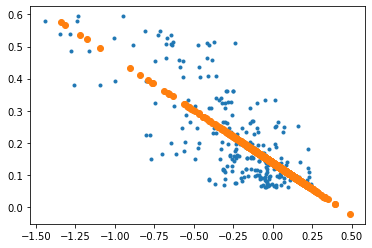

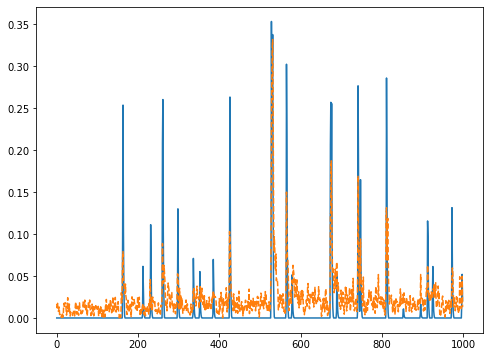

In [111]:
y = np.sqrt(np.concatenate([AOD[AOD>AODmin],AOD[AOD>AODmin]]))
x = np.concatenate([np.roll(dT1glob[AOD>AODmin], -1), np.roll(dT2glob[AOD>AODmin], -1)])
X = sm.add_constant(x)

model = sm.OLS(y, X)
fit = model.fit()
print(fit.summary())

xpl = np.roll(dTglob, -1)
Xpl = sm.add_constant(xpl)
ypred = fit.predict(Xpl)

plt.figure()
plt.plot(x, y, '.')
plt.plot(xpl, ypred, 'o')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(t, AOD, '-')
ax.plot(t, ypred**2, '--')
#plt.fill_between(t, dTglob - err_dTglob, dTglob + err_dTglob)


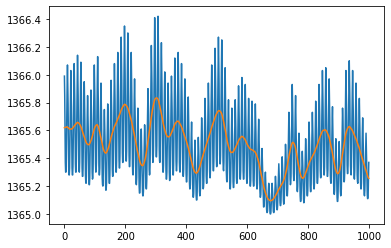

In [113]:
TSI_sm = gaussian_filter(TSI, 6)

plt.figure()
plt.plot(TSI)
plt.plot(TSI_sm)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     263.6
Date:                Thu, 02 Apr 2020   Prob (F-statistic):           9.86e-56
Time:                        23:40:07   Log-Likelihood:                 904.18
No. Observations:                1976   AIC:                            -1804.
Df Residuals:                    1974   BIC:                            -1793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1365.4956      0.003   3.96e+05      0.0

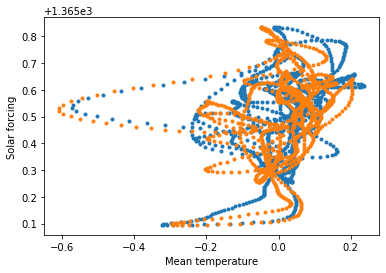

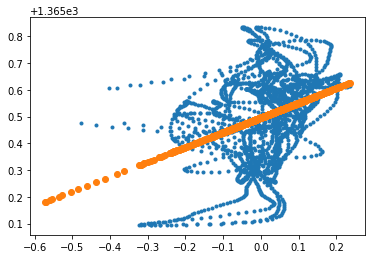

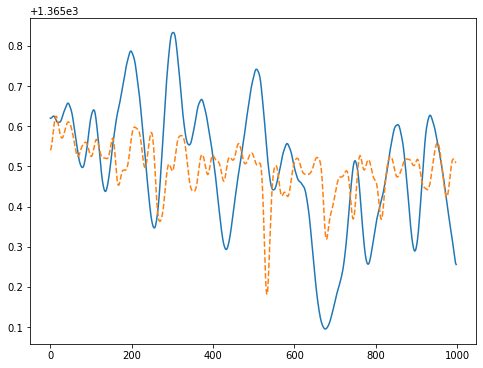

In [120]:
dTmin = -0.4

y = TSI_sm
dT1glob_sm = gaussian_filter(dT1glob, 6)
dT2glob_sm = gaussian_filter(dT2glob, 6)
xA = dT1glob_sm
xB = dT2glob_sm

plt.figure()
plt.plot(xA, y, '.')
plt.plot(xB, y, '.')
plt.xlabel('Mean temperature')
plt.ylabel('Solar forcing')

x = np.concatenate([xA[dT1glob_sm > dTmin], xB[dT1glob_sm > dTmin]])
y = np.concatenate([y[dT1glob_sm > dTmin], y[dT1glob_sm > dTmin]])
X = sm.add_constant(x)

model = sm.OLS(y, X)
fit = model.fit()
print(fit.summary())

xpl = dT1glob_sm
Xpl = sm.add_constant(xpl)
ypred = fit.predict(Xpl)

plt.figure()
plt.plot(x, y, '.')
plt.plot(xpl, ypred, 'o')

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(t, TSI_sm, '-')
ax.plot(t, ypred, '--')

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │  4.57939   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 50         │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.0457939 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════

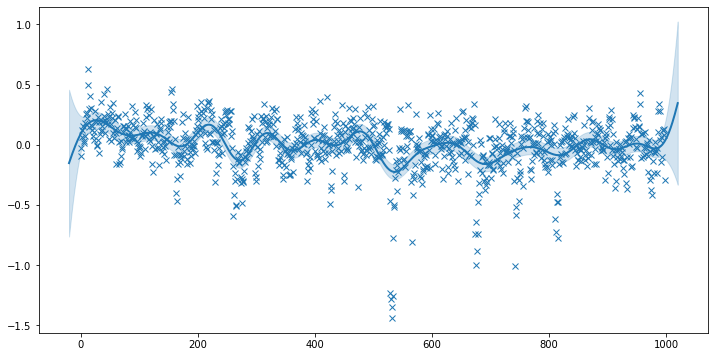

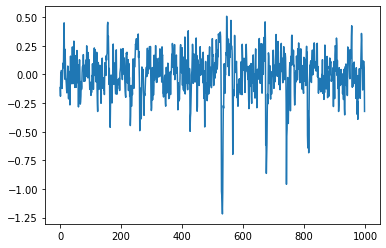

In [174]:
import gpflow
from gpflow.utilities import print_summary, set_trainable

# datavar = np.mean(var_dTglob)

xtrain = t.reshape([-1,1]).astype(np.float64)
ytrain = dT1glob.reshape([-1,1]).astype(np.float64)

k = gpflow.kernels.SquaredExponential(variance=1e2*np.var(ytrain), lengthscales=50)
#meanf = gpflow.mean_functions.Constant()
m = gpflow.models.GPR(data=(xtrain, ytrain), kernel=k, noise_variance=np.var(ytrain))#, mean_function=meanf)
opt = gpflow.optimizers.Scipy()

set_trainable(m.kernel.variance, False)
#set_trainable(m.likelihood.variance, False)

print_summary(m)

def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))

print_summary(m)

xpl = np.linspace(-20, 1020, 1041).reshape([-1, 1]).astype('float64')
mean, var = m.predict_f(xpl, full_cov=False)
mean0, var0 = m.predict_f(xtrain, full_cov=False)

plt.figure(figsize=(12, 6))
plt.plot(xtrain, ytrain, 'x')
plt.plot(xpl, mean, 'C0', lw=2)
plt.fill_between(xpl[:, 0],
                 mean[:, 0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:, 0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.figure()
plt.plot(xtrain, ytrain-mean0)

In [163]:
var

<tf.Tensor: shape=(1041, 1), dtype=float64, numpy=
array([[0.09693854],
       [0.08681266],
       [0.07752189],
       ...,
       [0.09693854],
       [0.10794452],
       [0.11987552]])>

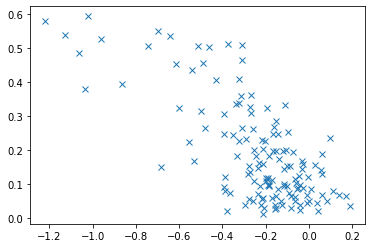

In [179]:
plt.figure()
y = ytrain-mean0
plt.plot(np.roll(y,-1)[AOD>AOD_min], np.sqrt(AOD[AOD>AOD_min]), 'x')